In [203]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from multiprocessing import Pool, shared_memory

In [204]:
class _LocalFunctions:
    @classmethod
    def add_functions(cls, *args):
        for function in args:
            setattr(cls, function.__name__, function)
            function.__qualname__ = cls.__qualname__ + '.' + function.__name__

In [239]:
def sample_matrix(n, S, p_diag, p_off_diag):
    """Sample a random matrix
       n:          the size of the matrix (n,n).
       S:          the average number of non-zero off-diagonal elements.
       p_diag:     The function that samples n elements for diagonal terms
                   it must have a signiture like p_diag(n,S).
       p_off_diag: The function that samples (n,n) elements for off-diagonal terms
                   it must have a signiture like p_off_diag(n,S).
    """
    
    # A binomial distribution with p=S/n always have the mean equals S
    # By setting N=1, we get 0 or one for each trials, which on average
    # S times is 1
    # So, the following create an n by n matrices of zeros and one such that
    # the expectation of getting non-zero element is S
    if S > n-1:
        p = 1.0
    else:
        p = S/(n-1)
    off_diag_indices = np.random.binomial(1, p, (n, n))
    # Since we sample the  diagonal terms differently, we fill their indices by one
    off_diag_indices[np.diag_indices(n)] = 0
    #print(off_diag_indices)
    
    # Create an n by n matrices, sampled from 'p_off_diag' distribution
    m = p_off_diag(n, S)
    #print(m)
    # Remove all the terms that is supposed to be zero (no regulation)
    # including the diagonals
    m = m*off_diag_indices
    #print(m)
    # Fill the diagonal terms by sampling from 'p_diag' distribution
    m[np.diag_indices(n)] = p_diag(n, S)
    #print(m)
    return m
    
    

In [240]:
def p_diag_uniform(low):
    def uniform(n, S):
        return np.random.uniform(low, -1e-8, n)    
    return uniform

def p_off_diag_uniform():
    def uniform(n, S):        
        return np.random.uniform(-1/S, 1/S, (n,n))    
    return uniform

def p_off_diag_scaled_uniform(alpha):
    def uniform(n, S):        
        return np.random.uniform(-alpha/S, alpha/S, (n,n))    
    return uniform

def is_unstable(m):
    """Find the linear stability of a matrix"""
    return np.any(np.real(sp.linalg.eigvals(m)) > 0)

In [243]:
#a=sample_matrix(4,4, p_diag_uniform(-4), p_off_diag_uniform())
count = 100000
matrices = [sample_matrix(4,3, p_diag_uniform(-10), p_off_diag_scaled_uniform(4)) for _ in range(count)]

In [244]:
res = [is_unstable(m) for m in matrices]
unstable = np.sum(res)
print(f"{unstable} out of {count}, p = {100*unstable/count:.5f}%")

5440 out of 100000, p = 5.44000%


In [212]:
sizes = np.power(2,np.arange(2,11))
count = 1000
S = 4
p_diag_low = -10
scales = np.array([1, 2, 3, 4, 5])
unstables = np.zeros((scales.shape[0], sizes.shape[0]))
ratios = np.zeros((scales.shape[0], sizes.shape[0]))



def proc_stability(args):
    n, S, p_diag_low, scale, count = args
    matrices = [sample_matrix(n,S, p_diag_uniform(p_diag_low), p_off_diag_scaled_uniform(scale)) for _ in range(count)]
    res = [is_unstable(m) for m in matrices]
    unstable = np.sum(res)
    return (unstable, unstable/count)    

params = [ (n, S, p_diag_low, scale, count) for scale in scales for n in sizes]
with Pool(55) as pool:
    res = pool.map(proc_stability, params)
# for i, scale in enumerate(scales):
#     for j, n in enumerate(sizes):
#         matrices = [sample_matrix(n,S, p_diag_uniform(-10), p_off_diag_scaled_uniform(scale)) for _ in range(count)]
#         res = [is_unstable(m) for m in matrices]
#         unstable = np.sum(res)
#         unstables[i,j] = unstable
#         ratios[i,j] = unstable/count
#         print(f" (n,n):{(n,n)}, {unstable} out of {count}, p = {100*unstable/count:.5f}%")
        

In [217]:
index = 0
for i, scale in enumerate(scales):
    for j, n in enumerate(sizes):
        unstables[i,j] = res[index][0]
        ratios[i,j] = res[index][1]
        index += 1

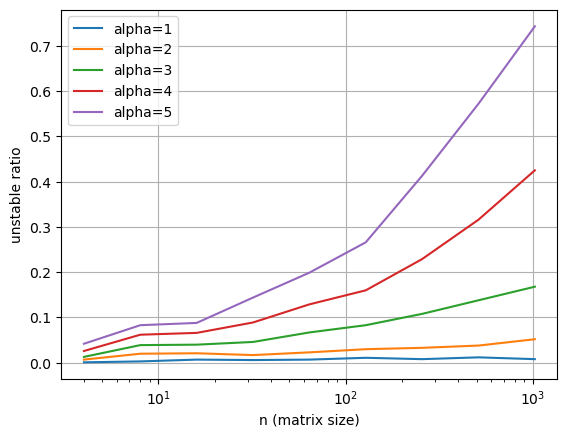

In [222]:
for i, scale in enumerate(scales):
    plt.plot(sizes, ratios[i, :], label=f"alpha={scale}")
    
plt.xlabel("n (matrix size)");plt.ylabel("unstable ratio")    
plt.grid();plt.legend();plt.xscale('log');plt.show()

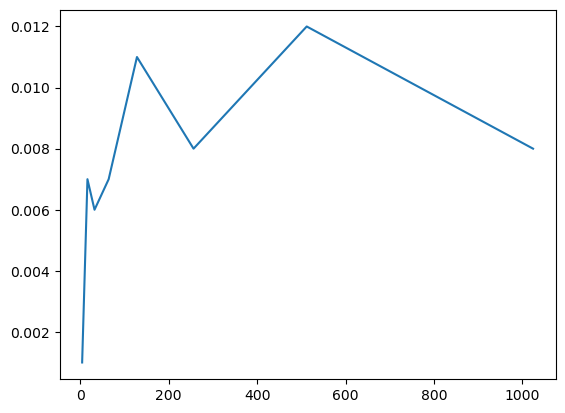

In [223]:
plt.plot(sizes, ratios[0, :])

In [245]:
sizes2 = np.power(2,np.arange(2,11))
count = 1000
S = 4
p_diag_low = -10
repeat = 10
unstables2 = np.zeros((repeat, sizes2.shape[0]))
ratios2 = np.zeros((repeat, sizes2.shape[0]))


params2 = [ (n, S, p_diag_low, 0.4 , count) for _ in range(repeat) for n in sizes2]

In [246]:
with Pool(55) as pool:
    res2 = pool.map(proc_stability, params2)

In [372]:
res2[8::9]

[(2, 0.002),
 (2, 0.002),
 (2, 0.002),
 (2, 0.002),
 (2, 0.002),
 (2, 0.002),
 (2, 0.002),
 (0, 0.0),
 (0, 0.0),
 (3, 0.003)]

In [373]:
np.mean([ a[1] for a in res2[8::9]])

0.0017000000000000001

In [376]:
ratios2[:, -1]

array([0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.   , 0.   ,
       0.003])

In [379]:
np.mean(ratios2, axis=0)

array([0.0001, 0.0009, 0.0007, 0.002 , 0.0019, 0.0014, 0.0032, 0.0013,
       0.0017])

In [363]:
index = 0
for i in range(repeat):
    for j, n in enumerate(sizes):
        unstables2[i,j] = res2[index][0]
        ratios2[i,j] = res2[index][1]
        index += 1

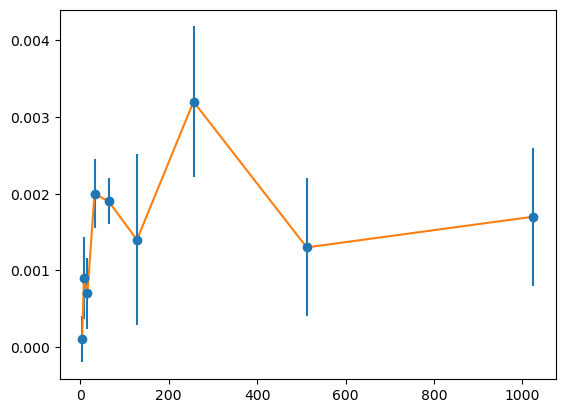

In [374]:
plt.errorbar(sizes,np.mean(ratios2, axis=0), np.std(ratios2, axis=0), linestyle='None', marker='o')
plt.plot(sizes,np.mean(ratios2, axis=0))

In [499]:

#aaa = p_off_diag_scaled_uniform(.4)(5, S)
n=1000
aaa = sample_matrix(n, S, 
                   p_diag_uniform(-10), 
                   p_off_diag_scaled_uniform(.4))

In [500]:
bbb = aaa - np.diag(np.diag(aaa))
bbb[np.diag_indices(n)] = -10
np.mean(n-1-np.sum(bbb == 0, axis=1)), np.sum(bbb == 0)/(n*(n-1))

(4.04, 0.995955955955956)

In [501]:
ccc = np.abs((aaa- np.diag(np.diag(aaa))))
S*np.mean(
    np.sum(ccc, axis=1)/(1e-10+np.sum(np.where(ccc > 0, 1, 0), axis=1))
)

0.19587472961464494

In [502]:
np.any(np.diag(aaa) - np.sum(ccc, axis=1) > 0)

False

In [503]:
is_unstable(aaa)

False

In [507]:
def matrix_intervals(m, axis=1):
    """Turn a matrix to row(column)-wise intervals
    
       args:
           m: (n,n) numpy array.
           axis:  use one for row-wise and zero for
                  column-wise intervals.
    """
    # Get the diagonal terms
    ds = np.diag(m)
    # Sum of absolute value of off-diagonal elements
    rs = np.sum(np.abs(m - np.diag(ds)), axis = axis)
    # create intrvals around the diagonal terms
    return np.array([ (d-r, d+r) for d, r in zip(ds, rs) ])

#
# a = np.arange(0,9).reshape((3,3))
# assert np.all(matrix_intervals(a,1) == np.array([[-3,  3],
#                                                  [-4, 12],
#                                                  [-5, 21]]))
# assert np.all(matrix_intervals(a,0) == np.array([[-9,  9],
#                                                  [-4, 12],
#                                                  [ 1, 15]]))


def alg1(m, axis=1):
    """Specifies the stabaility property of the matrix.
    
       args:
           m: (n,n) numpy array.
           axis:  use one for row-wise and zero for
                  column-wise intervals.
       return:
               0 - super-stable
               1 - inconclusive
               2 - unstable
    
    """
    n = m.shape[0]
    intervals = matrix_intervals(m,axis)
    us = np.array([u for _,u in intervals])
    ls = np.array([l for l,_ in intervals])
    u_max_index = np.argmax(us)
    u_max = us[u_max_index]    
    if u_max < 0:# Super-stable
        return 0
    
    l_i = ls[u_max_index] 
    if l_i < 0:# Inconclusive
        return 1
    indices = [i for i in range(0, n) if i != u_max_index]
    for j in indices:
        l_j, u_j = ls[j], us[j]
        if l_i < u_j:
            if l_j < l_i:
                l_i = l_j
            if l_i < 0:# Inconclusive
                return 1
    return 2# unstable            

def alg2(m, axis=1):
    """Specifies if the stabaility property can be tightened.
    
       args:
           m: (n,n) numpy array.
           axis:  use one for row-wise and zero for
                  column-wise intervals.
       return:
               0 - super-stable
               1 - inconclusive
               2 - unstable
    
    """
    n = m.shape[0]
    # Get the diagonal terms
    ds = np.diag(m)
    # Sum of absolute value of off-diagonal elements
    rs = np.sum(np.abs(m - np.diag(ds)), axis = axis)
    a_max_index = np.argmax(ds)
    a_ii = ds[a_max_index]
    r_i = rs[a_max_index]
    indices = [i for i in range(0, n) if i != a_max_index]
    if a_ii > 0:        
        for j in indices:
            r_j = rs[j]
            a_jj = m[j,j]
            if axis == 0:
                a_ji = m[j, a_max_index]
            else:
                a_ji = m[a_max_index, j]
            c_0 = r_i
            c_1 = a_jj-a_ii+r_j-np.abs(a_ji)
            c_2 = np.abs(a_ji)                        
            d_max = np.real(np.max(np.roots([c_2, c_1, c_0])))
            if d_max <= r_i/(a_ii+1e-30):
                return 1 # Inconclusive
            if c_1 >= 0:                
                return 1 # Inconclusive
            if c_1*c_1 <= 4*np.abs(a_ji*r_i):                
                return 1 # Inconclusive
        return 2 # Unstable
    else:
        #r_j = rs[j]
        #a_jj = m[j,j]
        #a_ji = m[j, a_max_index]
        #if r_i/np.abs(a_ii) >= np.min([ (np.abs(a_jj)-r_j)/np.abs(a_ji)  for j in indices]):
        # select r_i, a_jj and a_ji
        if axis == 0:
            parts = [(rs[j], m[j,j], m[j, a_max_index]) for j in indices]
        else:
            parts = [(rs[j], m[j,j], m[a_max_index, j]) for j in indices]
        values = [(np.abs(a_jj)-r_j)/(np.abs(a_ji) + 1e-20)  for (r_j, a_jj, a_ji) in parts]
        if r_i/(np.abs(a_ii) + 1e-20) >= np.min(values):
            return 1 # Inconclusive
        return 0 # Super-stable

def alg(m):
    ret = alg1(m, axis = 0)
    if ret != 1:
        return ret
    ret = alg1(m, axis = 1)
    if ret != 1:
        return ret
    ret = alg2(m, axis = 0)
    if ret != 1:
        return ret
    return alg2(m, axis = 1)

In [655]:
def p_off_diag_uniform_fixed(L):
    def uniform(n, S):        
        return np.random.uniform(-L, L, (n,n))    
    return uniform



count = 100
n=4000
S=10
L=S/n
#L=.01
#S = int(L*n)

print(L, S)
matrices = [sample_matrix(n,S, p_diag_uniform(-n), p_off_diag_uniform_fixed(L)) for _ in range(count)]

0.0025 10


In [656]:
from collections import Counter

types = [alg(m) for m in matrices]
stats = Counter(types)
#stats
for k,v in stats.items():
    if k == 0:
        type_is = "Super-stable"
    elif k == 1:
        type_is = "Inconclusive"
    else:
        type_is = "Unstable"
    print(f"{type_is}: {v} , {100*v/count}%")

Super-stable: 100 , 100.0%


In [693]:
def prob_x_less_y(c, x_mean, x_sigma):
    sq_2 = np.sqrt(2)
    
    def phi(x, mu, sigma):
        return 0.5*(1 + sp.special.erf((np.log(x) - mu)/(sq_2*sigma)))
    
    return (phi(c, x_mean, x_sigma) 
            - np.exp((x_sigma**2/2) + x_mean)* phi(c, x_mean + x_sigma**2, x_sigma)/c)

In [694]:
c = 1
x_mean = 0
x_sigma = 1/4
print(prob_x_less_y(c, x_mean, x_sigma))

0.08596789705226454


In [691]:
repeat = 100
samples = np.zeros(repeat)
n = 1000000

for i in range(repeat):
    ys = np.random.uniform(low = 0, high = c, size=n)
    xs = np.random.lognormal(mean = x_mean, sigma = x_sigma, size=n)
    samples[i] = np.sum(xs < ys)/n

In [692]:
np.mean(samples), np.std(samples)

(0.08598024000000003, 0.0002833860659947839)

In [745]:
es = .1
eas = np.linspace(0, 1, 100)
varas = np.linspace(0, 1, 100)

Means, Sigmas = np.meshgrid(es*eas, es*varas)
c=10
ps = prob_x_less_y(c, Means, Sigmas)

/tmp/ipykernel_30057/802534803.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return 0.5*(1 + sp.special.erf((np.log(x) - mu)/(sq_2*sigma)))


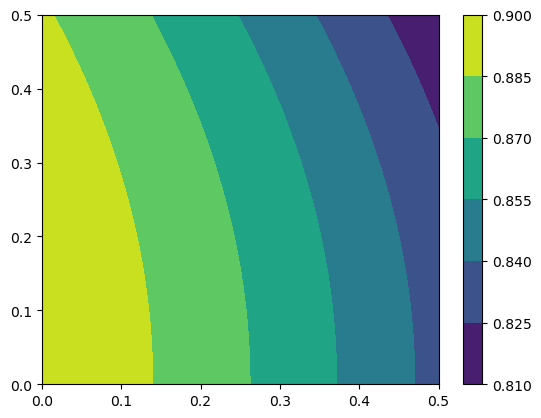

In [744]:
plt.contourf( Means, Sigmas ,ps)
plt.colorbar()